In [96]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [90]:
het_cyto_data = pd.read_csv('../data/het_cyto_data.tsv', sep='\t', index_col=0)
alpha_div = pd.read_csv('../data/alpha-div.tsv', sep='\t', index_col=0)
het_cyto_data['q=2'] = alpha_div['q=2'].reindex(het_cyto_data.index)

In [91]:
het_cyto_data

,IL-6,MCP-1,IL-1b,TNF-a,IL-10,IL-8,mean_het_lvl,disease,q=2
5,220.947754,43.464305,2.795976,307.813620,75.573990,8.518603,0.095706,1,3.000000
6,99.129891,12.545548,1.970814,12.892022,14.675090,157.289657,0.371491,1,2.777778
7,71.148681,3.026672,2.425959,24.003158,23.084995,1.000000,0.089496,1,3.000000
11,20.000000,1.215848,3.190663,24.434444,24.109061,1.000000,0.448596,1,2.333333
13,88.591794,4.507878,1.888006,20.632980,34.908852,2.485923,0.253391,1,2.272727
15,36.828329,0.962080,1.821174,12.118703,17.131901,1.000000,0.087325,1,2.777778
27,412.888465,11.685180,5.505951,41.587768,344.189944,8.995548,0.088332,1,3.000000
31,158.174432,11.314378,4.322621,72.791282,79.709176,1.813686,0.090535,1,3.000000
40,2990.356958,91.986430,3.861303,77.112394,1225.374613,6.205014,0.083177,1,2.571429
46,331.646638,226.317705,36.819897,178.050036,154.324930,18.253838,0.083149,0,2.272727


In [ ]:
X = het_cyto_data.drop('disease', axis=1)
y = het_cyto_data['disease']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
print(f"Before SMOTE: Class 0: {sum(y == 0)}, Class 1: {sum(y == 1)}")
print(f"After SMOTE: Class 0: {sum(y_resampled == 0)}, Class 1: {sum(y_resampled == 1)}")

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.2)

param_grid_improved = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.8],
    'bootstrap': [True, False]
}


random_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced'),
    param_grid_improved,
    n_iter=100,
    cv=10,
    scoring='roc_auc',
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best score:", random_search.best_score_)
print("Best params:", random_search.best_params_)

model = random_search.best_estimator_

Before SMOTE: Class 0: 37, Class 1: 20
After SMOTE: Class 0: 37, Class 1: 37
Best score: 0.7944444444444445
Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


Feature Importance:
        feature  importance
3         TNF-a    0.206001
0          IL-6    0.146814
4         IL-10    0.124624
1         MCP-1    0.124080
6  mean_het_lvl    0.123951
2         IL-1b    0.108425
5          IL-8    0.108206
7           q=2    0.057899


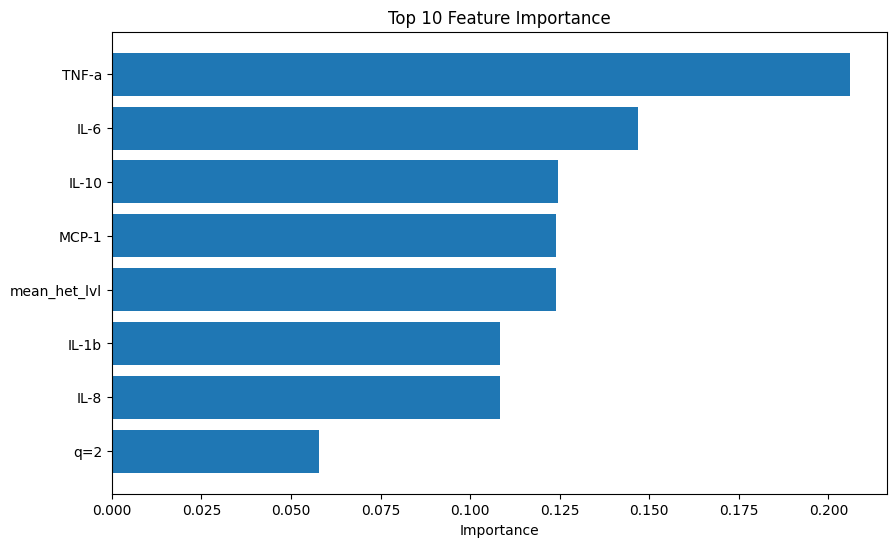

In [ ]:
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df.head(10))


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'][:10], feature_importance_df['importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Logistic Regression (balanced):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

Logistic Regression (balanced):
Accuracy: 0.600
Precision: 0.600
Recall: 0.429
F1-score: 0.500
ROC-AUC: 0.643
